<a href="https://colab.research.google.com/github/Moue224/Portafolio_inversion_Optimizacion_Multiobjetivo/blob/main/Metodos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CARGAMOS LIBRERIA Y DATOS

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.express import line as line_chart
import numpy as np
from datetime import datetime, timedelta
from scipy.optimize import minimize
from scipy import optimize
import time

In [2]:
%%capture
# Instalación de Pyomo como paquete de modelado
!pip install pyomo

In [3]:
%%capture
!apt-get install -y -qq glpk-utils

In [4]:
%%capture

!apt-get install -y -qq coinor-cbc

In [5]:
%%capture

!pip install -q amplpy
MODULES, LICENSE_UUID = ["coin"], " NLicumb"
from amplpy import AMPL, tools
ampl = tools.ampl_notebook(modules=MODULES, license_uuid=LICENSE_UUID, g=globals()) # instantiate AMPL object and register magics


In [7]:
# Importación de los paquetes de Python
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [8]:
tickers =  ['AAPL', 'GOOGL', 'TSLA', 'AMZN', 'MSFT', 'AAL', 'EFX', 'FDX', 'JPM', 'KO']
acciones = ['APPLE','GOOGLE', 'TESLA','AMAZON', 'MICROSOFT', 'American Airlines Group', 'Equifax', 'FedEx', 'JP Morgan Chase', 'Coca-Cola']

In [9]:
# Fecha de analisis
start_date = '2023-01-01'

end_date = '2024-02-29'

In [10]:
adj_close_df = pd.DataFrame()

In [11]:
for ticker in tickers:
  data = yf.download(ticker, start=start_date, end = end_date)
  adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [12]:
print(adj_close_df)

                  AAPL       GOOGL        TSLA        AMZN        MSFT    AAL  \
Date                                                                            
2023-01-03  124.216293   89.120003  108.099998   85.820000  237.036011  12.74   
2023-01-04  125.497498   88.080002  113.639999   85.139999  226.667282  13.59   
2023-01-05  124.166641   86.199997  110.339996   83.120003  219.949371  13.99   
2023-01-06  128.735245   87.339996  113.059998   86.080002  222.541565  14.18   
2023-01-09  129.261642   88.019997  119.769997   87.360001  224.708298  14.61   
...                ...         ...         ...         ...         ...    ...   
2024-02-22  184.369995  144.089996  197.410004  174.580002  411.649994  15.24   
2024-02-23  182.520004  143.960007  191.970001  174.990005  410.339996  15.13   
2024-02-26  181.160004  137.570007  199.399994  174.729996  407.540009  15.28   
2024-02-27  182.630005  138.880005  199.729996  173.539993  407.480011  15.54   
2024-02-28  181.419998  136.

In [ ]:
fig = line_chart(adj_close_df.iloc[:, :len(tickers)])
fig.update_layout(
    title="Time Series Chart of Adjusted Close Prices",
    xaxis_title="Date",
    yaxis_title="Adjusted Close Price",
)

fig.show()

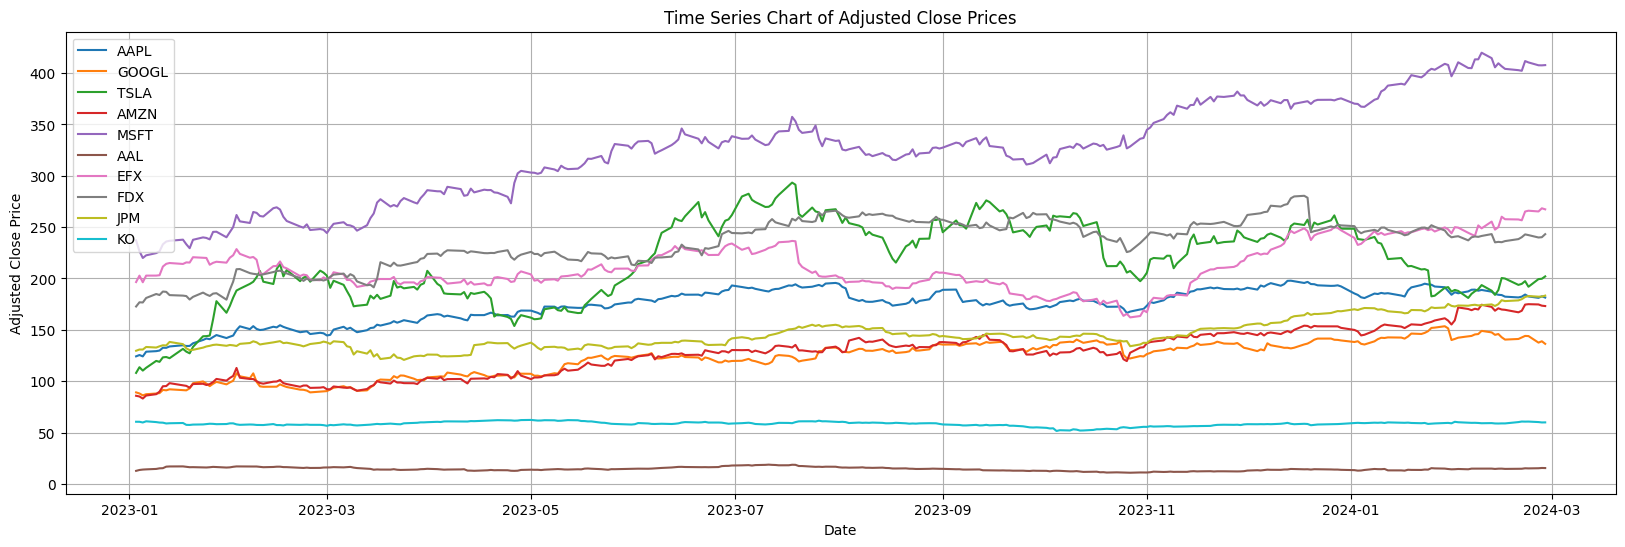

In [31]:
plt.figure(figsize=(20, 6))

for ticker in tickers:
    plt.plot(adj_close_df.index, adj_close_df[ticker], label=ticker)


plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Time Series Chart of Adjusted Close Prices')
plt.legend()
plt.grid(True)


plt.show()

Notamos una alta variablidad de los precios, esto nos puede traer problemas en un futuro. Decidimos aplicar logarítmo, así reducimos la varianza.

In [13]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

In [14]:
log_returns

,AAPL,GOOGL,TSLA,AMZN,MSFT,AAL,EFX,FDX,JPM,KO
Date,,,,,,,,,,
2023-01-04,0.010261,-0.011738,0.049979,-0.007955,-0.044729,0.064588,0.031274,0.023306,0.009282,-0.000477
2023-01-05,-0.010661,-0.021575,-0.029469,-0.024012,-0.030086,0.029009,-0.032334,-0.000937,-0.000221,-0.011509
2023-01-06,0.036133,0.013138,0.024352,0.034992,0.011717,0.013490,0.032383,0.024467,0.018955,0.019109
2023-01-09,0.004081,0.007756,0.057655,0.014760,0.009689,0.029874,0.000098,0.021145,-0.004141,-0.012539
2023-01-10,0.004446,0.004534,-0.007711,0.028327,0.007588,0.038931,0.001758,-0.005284,0.008914,-0.007696
...,...,...,...,...,...,...,...,...,...,...
2024-02-22,0.011181,0.010745,0.013463,0.034913,0.023274,0.029972,0.032735,0.011327,0.011924,-0.001471
2024-02-23,-0.010085,-0.000903,-0.027944,0.002346,-0.003187,-0.007244,0.003012,-0.002871,0.005013,0.000817
2024-02-26,-0.007479,-0.045403,0.037974,-0.001487,-0.006847,0.009865,-0.002748,-0.009658,-0.003430,-0.008039


In [15]:
cov_matrix = log_returns.cov()*252 # son los dias que se trabaja

In [16]:
cov_matrix

,AAPL,GOOGL,TSLA,AMZN,MSFT,AAL,EFX,FDX,JPM,KO
AAPL,0.039532,0.032104,0.041280,0.027946,0.026127,0.022723,0.022594,0.019034,0.010473,0.004667
GOOGL,0.032104,0.091902,0.043870,0.058096,0.038357,0.020325,0.028802,0.024312,0.009642,0.003941
TSLA,0.041280,0.043870,0.269433,0.058303,0.038187,0.056899,0.048897,0.036759,0.029024,0.001548
AMZN,0.027946,0.058096,0.058303,0.104926,0.046474,0.030638,0.036494,0.024496,0.008236,0.003704
MSFT,0.026127,0.038357,0.038187,0.046474,0.058404,0.017720,0.022014,0.020172,0.004574,0.004570
AAL,0.022723,0.020325,0.056899,0.030638,0.017720,0.142648,0.046529,0.040305,0.025200,0.000200
EFX,0.022594,0.028802,0.048897,0.036494,0.022014,0.046529,0.080644,0.025704,0.015347,0.004678
FDX,0.019034,0.024312,0.036759,0.024496,0.020172,0.040305,0.025704,0.069929,0.011848,0.006323
JPM,0.010473,0.009642,0.029024,0.008236,0.004574,0.025200,0.015347,0.011848,0.039271,0.005245
KO,0.004667,0.003941,0.001548,0.003704,0.004570,0.000200,0.004678,0.006323,0.005245,0.017799


In [17]:
# Retornos esperados
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

# Desviacion standar del portafolio
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

# PLANTEAMOS FUNCIONES

In [18]:
from pyomo.environ import *

def cargarModelo_nl(tickers, log_returns, cov_matrix):
    model = ConcreteModel()

    model.X = Var(tickers, within=NonNegativeReals) #NonNegativeReals o entero (NonNegativeIntegers)

    model.C1 = ConstraintList()
    for ticker in tickers:
      model.C1.add(model.X[ticker] >= 0)
      model.C1.add(model.X[ticker] <= 0.2)
    model.C2 = Constraint(expr = sum(model.X[ticker] for ticker in tickers) == 1)

    model.f1 = Var()
    model.f2 = Var()

    model.C_f1 = Constraint(expr = model.f1 == sum(sum(model.X[i] * model.X[j] * cov_matrix.loc[i, j] for j in tickers) for i in tickers))
    model.C_f2 = Constraint(expr = model.f2 == sum(model.X[ticker] * log_returns[ticker].mean() for ticker in tickers))

    model.O_f1 = Objective(expr = model.f1, sense=minimize)
    model.O_f2 = Objective(expr = model.f2, sense=maximize)

    return model


In [19]:
def encontrarExtremos(model, tickers):
    extremos = []

    model.O_f1.deactivate()
    model.O_f2.activate()
    solver = SolverFactory('ipopt') #ipopt
    solver.solve(model)
    f2_min = value(model.f2)
    f1_max = value(model.f1)

    model.O_f1.activate()
    model.O_f2.deactivate()
    solver.solve(model)
    f2_max = value(model.f2)
    f1_min = value(model.f1)

    model.O_f1.activate()

    return f2_min, f2_max, f1_min, f1_max, solver


In [20]:
model = cargarModelo_nl(tickers, log_returns, cov_matrix)
f2_min, f2_max, f1_min, f1_max, solver = encontrarExtremos(model, tickers)

# Imprime los resultados
print("Valor mínimo de f2:", f2_min)
print("Valor máximo de f2:", f2_max)
print("Valor mínimo de f1:", f1_min)
print("Valor máximo de f1:", f1_max)
print("Solver utilizado:", solver)

Valor mínimo de f2: 0.0018504768479164762
Valor máximo de f2: 0.0010858228495030891
Valor mínimo de f1: 0.01747195980252778
Valor máximo de f1: 0.05542286205799936
Solver utilizado: <pyomo.solvers.plugins.solvers.IPOPT.IPOPT object at 0x78f5d079d780>


In [21]:
# Vector Ideal
vector_ideal = [f1_min, f2_min]
print(f'Vector ideal: {vector_ideal[0]}, {vector_ideal[1]}')

# Vector antideal
vector_antideal = [f1_max, f2_max]
print(f'Vector nadir: {vector_antideal[0]}, {vector_antideal[1]}')

Vector ideal: 0.01747195980252778, 0.0018504768479164762
Vector nadir: 0.05542286205799936, 0.0010858228495030891


In [22]:
def encontrarExtremosLexicographic(model, tickers, log_returns, cov_matrix):
    solver = SolverFactory('ipopt') # bonmin - ipopt - cplex - glpk
    # Maximizo f1 libremente
    model.O_f2.deactivate()
    model.O_f1.activate()

    solver.solve(model)

    print('Extremo 1')
    print('Primer paso')
    print('Pesos:', [model.X[ticker].value for ticker in tickers])
    print( 'f1 = ' + str(value(model.f1)) )
    print( 'f2 = ' + str(value(model.f2)) )
    f1_min = value(model.f1)

    # Maximizo f2 sujeto a que f1 no empeore
    model.O_f2.activate()
    model.O_f1.deactivate()
    model.C_epsilon = Constraint(expr=model.f1 <= f1_min)

    solver.solve(model)

    print('Segundo paso')
    print('Pesos:', [model.X[ticker].value for ticker in tickers])
    print( 'f1 = ' + str(value(model.f1)) )
    print( 'f2 = ' + str(value(model.f2)) )

    # Tomo el mínimo de f2
    f2_min = value(model.f2)
    # Elimino restricción que impide empeorar a f1 para volver
    model.del_component(model.C_epsilon)

    # Maximizo f2 libremente
    model.O_f1.deactivate()
    model.O_f2.activate()

    solver.solve(model)

    print('Extremo 2')
    print('Primer paso')
    print('Pesos:', [model.X[ticker].value for ticker in tickers])
    print( 'f1 = ' + str(value(model.f1)) )
    print( 'f2 = ' + str(value(model.f2)) )
    f2_max = value(model.f2)

    # Maximizo f1 sujeto a que f2 no empeore
    model.O_f1.activate()
    model.O_f2.deactivate()
    model.C_epsilon = Constraint(expr = model.f2 >= f2_max)

    solver.solve(model)

    print('Segundo paso')
    print('Pesos:', [model.X[ticker].value for ticker in tickers])
    print( 'f1 = ' + str(value(model.f1)) )
    print( 'f2 = ' + str(value(model.f2)) )

    # Tomo el mínimo de f1 sobre el frente de Pareto
    f1_max = value(model.f1)

    model.del_component(model.C_epsilon)

    model.O_f1.activate()

    return f2_min, f2_max, f1_min, f1_max, solver


In [23]:
f2_min, f2_max, f1_min, f1_max, solver = encontrarExtremosLexicographic(model, tickers, log_returns, cov_matrix)

print(f'f2_min: {f2_min}, f2_max: {f2_max}, f1_min: {f1_min}, f1_max: {f1_max}')


Extremo 1
Primer paso
Pesos: [0.1999994267456771, 0.009790017529905626, 3.0271341302110037e-07, 4.117233599306268e-06, 0.18250433756097478, 0.004969566029396673, 0.07534810191480294, 0.1273843577380796, 0.19999984701269438, 0.1999999255214566]
f1 = 0.017471958246372158
f2 = 0.0010858192559247792
Segundo paso
Pesos: [0.19999995872173867, 0.009702232659798481, 1.75450232826534e-08, 3.5195439748180424e-07, 0.18306773946198954, 0.004752677959471602, 0.07518914237426155, 0.12728788105340313, 0.1999999957076701, 0.2000000025622462]
f1 = 0.01747196802669832
f2 = 0.0010863099742575765
Extremo 2
Primer paso
Pesos: [0.19988602487420246, 0.19998633220018033, 0.1999971463148297, 0.19999781176121612, 0.19999574626203015, 8.081418600371521e-06, 2.2294377262561784e-05, 4.728411781615171e-05, 5.550505691246838e-05, 3.7736169497043068e-06]
f1 = 0.05542286292415356
f2 = 0.0018504768478689688
Segundo paso
Pesos: [0.19957695012930468, 0.19999989288746375, 0.19999999772955532, 0.20000000314154315, 0.199999

In [24]:
# Vector Ideal
vector_ideal = [f1_min, f2_max]
print(f'Vector ideal: {vector_ideal[0]}, {vector_ideal[1]}')

# Vector antideal
vector_antideal = [f1_max, f2_min]
print(f'Vector nadir: {vector_antideal[0]}, {vector_antideal[1]}')

Vector ideal: 0.017471958246372158, 0.0018504768478689688
Vector nadir: 0.0554096242524237, 0.0010863099742575765


# METODO DE SUMAS PONDERADAS

In [25]:
def Normalized_Weighting_Sum(model, f1_min, f1_max, f2_min, f2_max, solver, n):

    model.O_f1.deactivate()
    model.O_f2.deactivate()

    # Peso de los vectores
    model.w1 = Param(initialize=0, mutable=True, within=NonNegativeReals)
    model.w2 = Param(initialize=0, mutable=True, within=NonNegativeReals)

    model.O_f = Objective(expr= ((model.f1 - f1_min) / (f1_max - f1_min)) * model.w1 + ((f2_max - model.f2) / (f2_max - f2_min)) * model.w2, sense=minimize)

    step = 1 / n

    x1_l = []
    x2_l = []
    f1_l = []
    f2_l = []

    inicio = time.time()

    for i in range(n):

        model.w1.set_value(i * step)
        cte = i * step
        model.w2.set_value(1 - cte)

        solver.solve(model)

        f1_l.append(value(model.O_f1))
        f2_l.append(value(model.O_f2))

        print("Sol vars - it:" + str(i) + " w1= " + str(cte) + " w2= " + str(1 - cte))
        print("Sol FO - it:" + str(i) + " f1= " + str(f1_l[len(f1_l) - 1]) + " f2= " + str(f2_l[len(f2_l) - 1]))


    fin = time.time()

    tiempo_transcurrido = fin - inicio
    df_Normalized_Weighting_Sum = pd.DataFrame({'f1': f1_l, 'f2': f2_l})

    print("Tiempo transcurrido:", tiempo_transcurrido, "segundos")
    print(df_Normalized_Weighting_Sum)

    plt.plot(f1_l, f2_l, 'o-.')
    plt.plot(0, 0, 'x-.')
    plt.title('Normalized Weighted Sum Pareto-front FO')
    plt.xlabel("f1", fontsize=10)
    plt.ylabel("f2", fontsize=10)
    plt.grid(True)
    plt.savefig("Normalized Weighted Sum - FO", dpi=600, bbox_inches="tight")
    plt.show()


    model.del_component(model.O_f)
    model.del_component(model.w1)
    model.del_component(model.w2)
    model.O_f1.activate()
    model.O_f2.activate()

Extremo 1
Primer paso
Pesos: [0.19999979845050803, 0.009787126699758526, 1.0346635855343249e-07, 1.4078680649460205e-06, 0.18250948404253017, 0.004959761335689642, 0.07535338273145256, 0.1273890051734404, 0.19999995087946648, 0.19999997935273062]
f1 = 0.01747195140468693
f2 = 0.001085822807803891
Segundo paso
Pesos: [0.19999996730661207, 0.009716239376738633, 1.2926742080358703e-08, 2.884946096687237e-07, 0.18297471560626832, 0.004787009772004562, 0.07521681045601065, 0.12730495415672738, 0.1999999980954455, 0.200000003808841]
f1 = 0.01747196122170341
f2 = 0.001086228491617077
Extremo 2
Primer paso
Pesos: [0.199886024703209, 0.19998633232155696, 0.19999714631989557, 0.19999781176422032, 0.19999574627316327, 8.081438076377795e-06, 2.229448400200437e-05, 4.7284155873608376e-05, 5.550491857030703e-05, 3.773621432622219e-06]
f1 = 0.05542286293268409
f2 = 0.001850476847868378
Segundo paso
Pesos: [0.1995769501240443, 0.1999998928874637, 0.19999999772955532, 0.20000000314154315, 0.19999999713

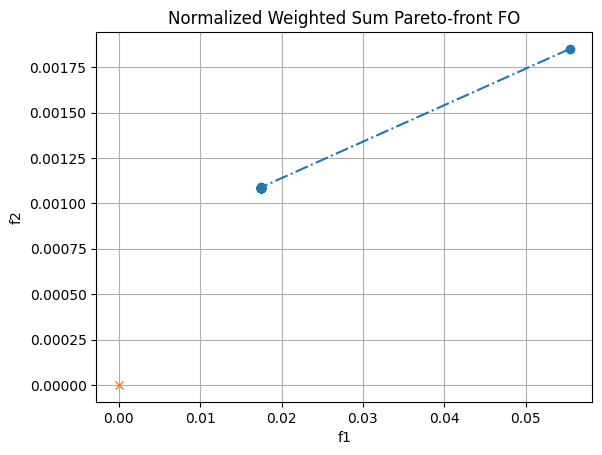

In [32]:

model = cargarModelo_nl(tickers, log_returns, cov_matrix)
f2_min, f2_max, f1_min, f1_max, solver = encontrarExtremosLexicographic(model, tickers, log_returns, cov_matrix)
n = 20
Normalized_Weighting_Sum(model, f2_min, f2_max, f1_min, f1_max, solver, n)

# METODO DE EPSILON RESTRICCIONES

In [ ]:
def Normal_Epsilon(model, f2_min, f2_max, solver, n):

    model.O_f1.activate()
    model.O_f2.deactivate()

    model.e = Param(initialize=0, mutable=True)
    model.C_epsilon = Constraint(expr = model.f2 >= model.e)

    step = (f2_max - f2_min) / n

    f1_l = []
    f2_l = []

    inicio = time.time()

    i = 0
    while i < n + 1:

        model.e = f2_min + i * step
        e_ = f2_min + i * step

        solver.solve(model)

        f1_l.append(value(model.f1))
        f2_l.append(value(model.f2))

        print("Epsilon " + str(e_))
        print("Sol FO - it:" + str(i) + " f1= " + str(f1_l[len(f1_l)-1]) + " f2= " + str(f2_l[len(f2_l)-1]))

        i = i + 1

    fin = time.time()

    tiempo_transcurrido = fin - inicio
    df_Normal_Epsilon = pd.DataFrame({'f1': f1_l, 'f2': f2_l})



    print("Tiempo transcurrido:", tiempo_transcurrido, "segundos")
    print(df_Normal_Epsilon)

    # Graficar el vector Ideal
    #plt.plot(vector_ideal[0], vector_ideal[1], 'ro', label='Vector Ideal')
    # Graficar el vector antideal
    #plt.plot(vector_antideal[0], vector_antideal[1], 'bo', label='Vector Antideal (Nadir)')

    # Frontera de Pareto
    plt.plot(f1_l,f2_l,'o-.')
    plt.title('Normal epsilon-Constraint Pareto-front FO')
    plt.xlabel("f1", fontsize = 10)
    plt.ylabel("f2", fontsize = 10)
    plt.grid(True)
    plt.show()
    plt.close()

    model.del_component(model.C_epsilon)
    model.del_component(model.e)


Extremo 1
Primer paso
Pesos: [0.19999942674407023, 0.009789854037004364, 3.0271319014161276e-07, 4.1184892743214874e-06, 0.18250439625833564, 0.004969493405354733, 0.075348382618323, 0.12738425319999402, 0.19999984701294587, 0.19999992552150772]
f1 = 0.017471955839957354
f2 = 0.0010858192806097496
Segundo paso
Pesos: [0.19999995874454754, 0.00970210049243678, 1.7532655730393028e-08, 3.517883073253484e-07, 0.18306755900184624, 0.004752668269454398, 0.07518951100554938, 0.12728783488554618, 0.1999999957140731, 0.2000000025655834]
f1 = 0.017471965620381547
f2 = 0.001086309797582665
Extremo 2
Primer paso
Pesos: [0.19988602467757632, 0.19998633221168904, 0.1999971463153367, 0.19999781176151468, 0.19999574626315497, 8.081420636429575e-06, 2.2294366576393142e-05, 4.7284195147083283e-05, 5.55051697308468e-05, 3.773618637588759e-06]
f1 = 0.05542287267385328
f2 = 0.0018504768053636085
Segundo paso
Pesos: [0.19957694929769665, 0.19999989288919237, 0.19999999772962954, 0.2000000031415734, 0.199999

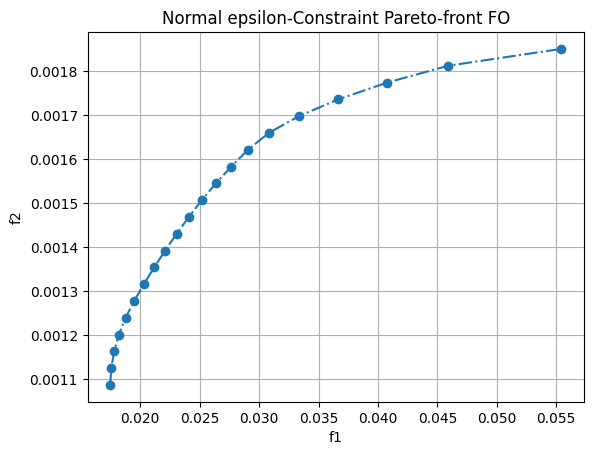

In [ ]:
f2_min, f2_max, f1_min, f1_max, solver = encontrarExtremosLexicographic(model, tickers, log_returns, cov_matrix)
n = 20
Normal_Epsilon(model, f2_min, f2_max, solver, n)

# METODO DE EPSILON RESTRICCIONES AUMENTADO

In [ ]:
def Aumented_Epsilon(model, f2_min, f2_max, solver, n):

    model.O_f1.deactivate()
    model.O_f2.deactivate()

    model.s = Var(within=NonNegativeReals)
    model.e = Param(initialize=0, mutable=True)
    model.C_e = Constraint(expr =  model.O_f2 - model.s == model.e)

    model.delta = Param(initialize=0.00001)


    model.O_f = Objective(expr = model.f1 + model.delta * model.s / (f2_max - f2_min), sense=minimize)


    x_l = []
    f1_l = []
    f2_l = []

    inicio = time.time() # registramos el tiempo

    step = (f2_max - f2_min)/n

    i = 0
    redundant_it = 0
    while i < n + 1:
        e_ = f2_min + i * step
        model.e = f2_min + i * step
        solver.solve(model)
        f1_l.append(value(model.O_f1))
        f2_l.append(value(model.O_f2))
        print(f"Epsilon {e_}")
        print(f"Sol FO - it:{i} f1= {f1_l[-1]} f2= {f2_l[-1]}")

        b = floor(value(model.s)/step)

        if b > 0:
            redundant_it += 1
        i = i + 1

    fin = time.time()

    tiempo_transcurrido = fin - inicio

    df_Aumented_Epsilon = pd.DataFrame({'f1': f1_l, 'f2': f2_l})


    print("Tiempo transcurrido:", tiempo_transcurrido, "segundos")
    print(df_Aumented_Epsilon)


    # Graficar el vector Ideal
    #plt.plot(vector_ideal[0], vector_ideal[1], 'ro', label='Vector Ideal')
    # Graficar el vector antideal
    #plt.plot(vector_antideal[0], vector_antideal[1], 'bo', label='Vector Antideal (Nadir)')

    plt.plot(f1_l,f2_l,'o-.')
    plt.title('Augmented epsilon-Constraint Pareto-front FO')
    plt.xlabel("f1", fontsize = 10)
    plt.ylabel("f2", fontsize = 10)
    plt.grid(True)
    plt.show()


    model.del_component(model.O_f)
    model.del_component(model.delta)
    model.del_component(model.e)
    model.del_component(model.s)
    model.del_component(model.C_e)

Extremo 1
Primer paso
Pesos: [0.19999942674558416, 0.009789637671761204, 3.027671432123612e-07, 9.347257280093406e-06, 0.1825007965790027, 0.004970577396686894, 0.0753466451471725, 0.12738349390304016, 0.19999984701077364, 0.1999999255215554]
f1 = 0.01747195740533879
f2 = 0.0010858228857765484
Segundo paso
Pesos: [0.19999995696807585, 0.00969919989125063, 1.8488580481984643e-08, 3.650217153050465e-07, 0.18308682280237282, 0.004745558803518422, 0.07518378126533067, 0.12728429923141305, 0.19999999522017142, 0.20000000230757148]
f1 = 0.017471967178174126
f2 = 0.0010863266714347824
Extremo 2
Primer paso
Pesos: [0.19988602471357955, 0.19998633218615003, 0.19999714631427082, 0.1999978117608826, 0.1999957462608126, 8.08141653878806e-06, 2.229434412534703e-05, 4.7284187210842874e-05, 5.550519873520816e-05, 3.7736176943653594e-06]
f1 = 0.05542287267206391
f2 = 0.0018504768053637336
Segundo paso
Pesos: [0.19957694929881303, 0.19999989288919237, 0.19999999772962954, 0.2000000031415734, 0.19999999

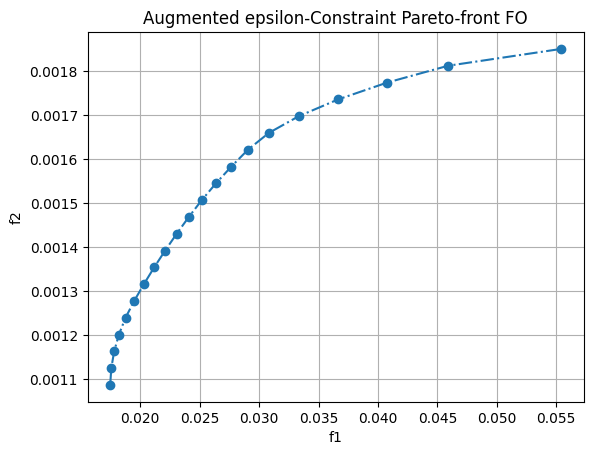

In [ ]:
f2_min, f2_max, f1_min, f1_max, solver =  encontrarExtremosLexicographic(model, tickers, log_returns, cov_matrix)
n = 20
Aumented_Epsilon(model, f2_min, f2_max, solver, n)

# CARTERA EFICIENTE

In [ ]:
def Investment_Normal_Epsilon(model, f2_min, f2_max, solver, n):

    model.O_f1.activate()
    model.O_f2.deactivate()

    model.e = Param(initialize=0, mutable=True)
    model.C_epsilon = Constraint(expr = model.f2 >= model.e)

    step = (f2_max - f2_min) / n

    x_optimo = []
    f1_l = []
    f2_l = []
    e_values = []

    inicio = time.time()

    i = 0
    while i < n + 1:

        model.e = f2_min + i * step
        e_ = f2_min + i * step

        solver.solve(model)

        f1_l.append(value(model.f1))
        f2_l.append(value(model.f2))
        e_values.append(e_)

        print("Epsilon " + str(e_))
        print("Sol FO - it:" + str(i) + " f1= " + str(f1_l[len(f1_l)-1]) + " f2= " + str(f2_l[len(f2_l)-1]))
        print("Valor de epsilon (e):", e_)


        x_optimo.append([value(model.X[ticker]) * 100 for ticker in tickers])

        i = i + 1

    fin = time.time()

    tiempo_transcurrido = fin - inicio
    df_Normal_Epsilon = pd.DataFrame({'f1': f1_l, 'f2': f2_l, 'x_optimo': [list(map(lambda x: round(x, 2), sublist)) for sublist in x_optimo]})


    # Guardar el DataFrame en un archivo CSV
    csv_filename = "resultados_epsilon_normal.csv"
    df_Normal_Epsilon.to_csv(csv_filename, index=False)

    print("Tiempo transcurrido:", tiempo_transcurrido, "segundos")
    print(df_Normal_Epsilon)
    print(x_optimo)

    # Graficar el vector Ideal
    #plt.plot(vector_ideal[0], vector_ideal[1], 'ro', label='Vector Ideal')
    # Graficar el vector antideal
    #plt.plot(vector_antideal[0], vector_antideal[1], 'bo', label='Vector Antideal (Nadir)')

    # Frontera de Pareto
    plt.plot(f1_l,f2_l,'o-.')
    plt.title('Método de las epsilon-restricciones', fontsize = 15)
    plt.xlabel("f1 (Variabilidad)", fontsize = 15)
    plt.ylabel("f2 (Retorno esperado)", fontsize = 15)
    plt.grid(True)
    plt.gcf().set_size_inches(8, 6)
    plt.savefig("Método de las epsilon-restricciones")
    plt.show()
    plt.close()

    plt.plot(range(len(e_values)), e_values, 'o-.', label='Valor de e_')
    plt.title('Variación de e_ en cada iteración')
    plt.xlabel('Iteraciones')
    plt.ylabel('Valor de e_')

    model.del_component(model.C_epsilon)
    model.del_component(model.e)


Epsilon 0.0010863266714254418
Sol FO - it:0 f1= 0.017471987585257805 f2= 0.0010864083441713042
Valor de epsilon (e): 0.0010863266714254418
Epsilon 0.0011245341781223564
Sol FO - it:1 f1= 0.017563839417327566 f2= 0.0011245243910593201
Valor de epsilon (e): 0.0011245341781223564
Epsilon 0.001162741684819271
Sol FO - it:2 f1= 0.017805499784042358 f2= 0.0011627317932106102
Valor de epsilon (e): 0.001162741684819271
Epsilon 0.0012009491915161855
Sol FO - it:3 f1= 0.018204928270352166 f2= 0.0012009393916743826
Valor de epsilon (e): 0.0012009491915161855
Epsilon 0.0012391566982131001
Sol FO - it:4 f1= 0.01876218382911326 f2= 0.0012391468487282324
Valor de epsilon (e): 0.0012391566982131001
Epsilon 0.0012773642049100148
Sol FO - it:5 f1= 0.019490234867753385 f2= 0.001277354248816779
Valor de epsilon (e): 0.0012773642049100148
Epsilon 0.0013155717116069294
Sol FO - it:6 f1= 0.020307146185122707 f2= 0.00131556182524343
Valor de epsilon (e): 0.0013155717116069294
Epsilon 0.001353779218303844
Sol 

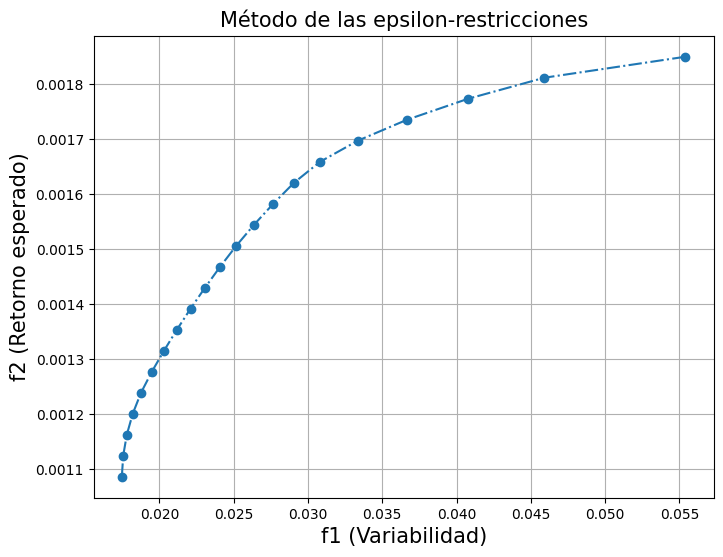

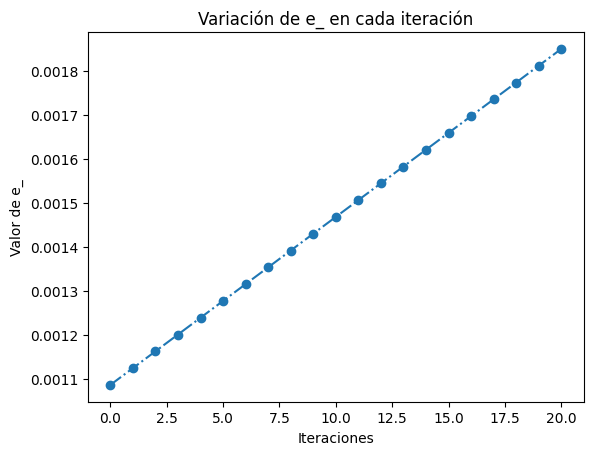

In [ ]:
n = 20
Investment_Normal_Epsilon(model, f2_min, f2_max, solver, n)

In [ ]:
def Investment_Aumented_Epsilon(model, f2_min, f2_max, solver, n):

    model.O_f1.deactivate()
    model.O_f2.deactivate()

    model.s = Var(within=NonNegativeReals)
    model.e = Param(initialize=0, mutable=True)
    model.C_e = Constraint(expr =  model.O_f2 - model.s == model.e)

    model.delta = Param(initialize=0.00001)


    model.O_f = Objective(expr = model.f1 + model.delta * model.s / (f2_max - f2_min), sense=minimize)


    x_optimo = []
    f1_l = []
    f2_l = []
    e_values = []

    inicio = time.time() # registramos el tiempo

    step = (f2_max - f2_min)/n

    i = 0
    redundant_it = 0
    while i < n + 1:
        e_ = f2_min + i * step
        model.e = f2_min + i * step
        solver.solve(model)
        f1_l.append(value(model.O_f1))
        f2_l.append(value(model.O_f2))
        e_values.append(e_)

        print(f"Epsilon {e_}")
        print(f"Sol FO - it:{i} f1= {f1_l[-1]} f2= {f2_l[-1]}")
        print("Valor de epsilon (e):", e_)

        x_optimo.append([value(model.X[ticker]) * 100 for ticker in tickers])

        b = floor(value(model.s)/step)

        if b > 0:
            redundant_it += 1
        i = i + 1

    fin = time.time()

    tiempo_transcurrido = fin - inicio

    df_Aumented_Epsilon = pd.DataFrame({'f1': f1_l, 'f2': f2_l, 'x_optimo': [list(map(lambda x: round(x, 2), sublist)) for sublist in x_optimo]})

    # Guardar el DataFrame en un archivo CSV
    csv_filename = "resultados_aumented_epsilon.csv"
    df_Aumented_Epsilon.to_csv(csv_filename, index=False)

    print("Tiempo transcurrido:", tiempo_transcurrido, "segundos")
    print(df_Aumented_Epsilon)
    print(x_optimo)


    # Graficar el vector Ideal
    #plt.plot(vector_ideal[0], vector_ideal[1], 'ro', label='Vector Ideal')
    # Graficar el vector antideal
    #plt.plot(vector_antideal[0], vector_antideal[1], 'bo', label='Vector Antideal (Nadir)')

    plt.plot(f1_l,f2_l,'o-.')
    plt.title('Método de las epsilon-restricciones aumentado', fontsize = 15)
    plt.xlabel("f1 (Variabilidad)", fontsize = 15)
    plt.ylabel("f2 (Retorno esperado)", fontsize = 15)
    plt.grid(True)
    plt.gcf().set_size_inches(8, 6)
    plt.savefig("Método de las epsilon-restricciones Aumentado")
    plt.show()

    plt.plot(range(len(e_values)), e_values, 'o-.', label='Valor de e_')
    plt.title('Variación de e_ en cada iteración')
    plt.xlabel('Iteraciones')
    plt.ylabel('Valor de e_')

    model.del_component(model.O_f)
    model.del_component(model.delta)
    model.del_component(model.e)
    model.del_component(model.s)
    model.del_component(model.C_e)

Epsilon 0.0010863266714347824
Sol FO - it:0 f1= 0.01747198643168646 f2= 0.0010863935925736312
Valor de epsilon (e): 0.0010863266714347824
Epsilon 0.00112453417813123
Sol FO - it:1 f1= 0.017563839412670475 f2= 0.001124524390417261
Valor de epsilon (e): 0.00112453417813123
Epsilon 0.0011627416848276775
Sol FO - it:2 f1= 0.01780549978264028 f2= 0.001162731793050152
Valor de epsilon (e): 0.0011627416848276775
Epsilon 0.001200949191524125
Sol FO - it:3 f1= 0.018204928267864056 f2= 0.0012009393914733204
Valor de epsilon (e): 0.001200949191524125
Epsilon 0.0012391566982205727
Sol FO - it:4 f1= 0.018762183831437705 f2= 0.0012391468486174317
Valor de epsilon (e): 0.0012391566982205727
Epsilon 0.0012773642049170202
Sol FO - it:5 f1= 0.0194902348677392 f2= 0.0012773542487960526
Valor de epsilon (e): 0.0012773642049170202
Epsilon 0.0013155717116134678
Sol FO - it:6 f1= 0.02030714618383698 f2= 0.0013155618251825723
Valor de epsilon (e): 0.0013155717116134678
Epsilon 0.0013537792183099153
Sol FO - i

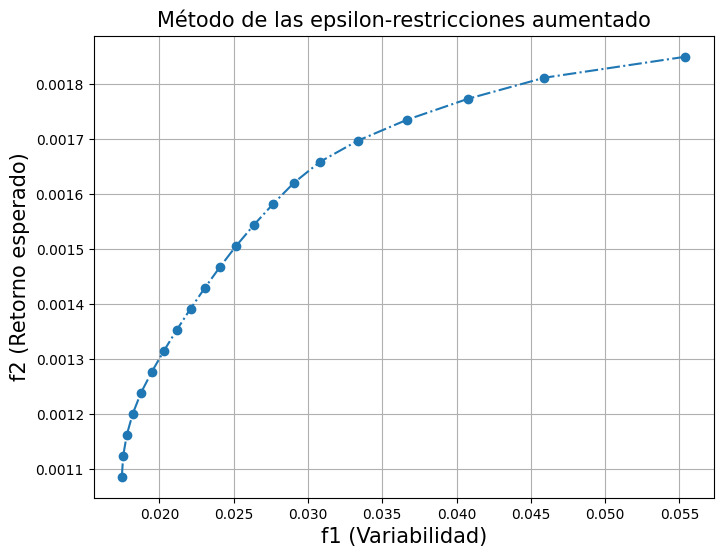

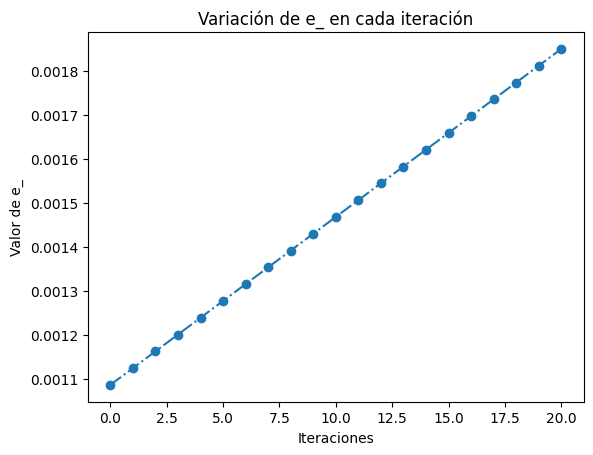

In [ ]:
n = 20
Investment_Aumented_Epsilon(model, f2_min, f2_max, solver, n)

# METRICAS

In [ ]:
def spacing(data):
    n = len(data)

    if n <= 1:
        return 0.0


    distances = np.linalg.norm(data - np.mean(data, axis=0), axis=1)
    mean_distance = np.mean(distances)


    spread_sum = np.sum(np.abs(distances - mean_distance))

    return spread_sum


df = pd.read_csv('resultados_aumented_epsilon.csv')


solutions = df[['f1', 'f2']].values

# Calcula el Spacing
spread_value = spacing(solutions)
print("Spacing:", spread_value)

Spacing: 0.09168759443784441


In [ ]:
def spread(data, f1_min, f1_max, f2_min, f2_max):
    n = len(data)

    if n <= 1:
        return 0.0


    min_distances = np.array([f1_min, f2_min])
    max_distances = np.array([f1_max, f2_max])


    distances = np.zeros((n,))
    for i, point in enumerate(data):
        distance = np.linalg.norm(point - min_distances)
        distance = min(distance, np.linalg.norm(point - max_distances))
        distances[i] = distance


    mean_distance = np.mean(distances)


    numerator = np.sum(min_distances) + np.sum(mean_distance - distances)
    denominator = np.sum(min_distances) + n * mean_distance
    spread_value = numerator / denominator

    return spread_value


df = pd.read_csv('resultados_aumented_epsilon.csv')


solutions = df[['f1', 'f2']].values


# Calcular el Spread
spread_value = spread(solutions, f1_min, f1_max, f2_min, f2_max)
print("Spread:", spread_value)


Spread: 0.1181802674427623


In [ ]:
# Modifico para encontrar la cantidad de puntos

def Normal_Epsilon(model, f2_min, f2_max, solver, n):

    model.O_f1.activate()
    model.O_f2.deactivate()

    model.e = Param(initialize=0, mutable=True)
    model.C_epsilon = Constraint(expr = model.f2 >= model.e)

    step = (f2_max - f2_min) / n

    unique_points = set()  # Conjunto para almacenar puntos únicos

    inicio = time.time()

    i = 0
    while i < n + 1:

        model.e = f2_min + i * step
        e_ = f2_min + i * step

        solver.solve(model)

        f1 = value(model.f1)
        f2 = value(model.f2)

        unique_points.add((f1, f2))  # Agregar el punto al conjunto


        i = i + 1

    fin = time.time()

    tiempo_transcurrido = fin - inicio
    df_Normal_Epsilon = pd.DataFrame({'f1': [point[0] for point in unique_points],
                                      'f2': [point[1] for point in unique_points]})

    print("Número de puntos distintos encontrados:", len(unique_points))
    print("Tiempo transcurrido:", tiempo_transcurrido, "segundos")
    print(df_Normal_Epsilon)

    model.del_component(model.C_epsilon)
    model.del_component(model.e)


In [ ]:
f2_min, f2_max, f1_min, f1_max, solver = encontrarExtremosLexicographic(model, tickers, log_returns, cov_matrix)
n = 10
Normal_Epsilon(model, f2_min, f2_max, solver, n)

Extremo 1
Primer paso
Pesos: [0.19999942674558416, 0.00978963767177815, 3.027671432124641e-07, 9.347257285017663e-06, 0.18250079657898613, 0.0049705773967005365, 0.0753466451471621, 0.12738349390303155, 0.19999984701077364, 0.1999999255215554]
f1 = 0.017471957405338766
f2 = 0.0010858228857765421
Segundo paso
Pesos: [0.19999995696807588, 0.009699199891288523, 1.8488580457674992e-08, 3.650217145492447e-07, 0.18308682280212368, 0.004745558803610377, 0.07518378126540493, 0.12728429923145868, 0.19999999522017142, 0.20000000230757148]
f1 = 0.017471967178174102
f2 = 0.0010863266714345636
Extremo 2
Primer paso
Pesos: [0.19988602471357955, 0.19998633218615003, 0.19999714631427082, 0.1999978117608826, 0.1999957462608126, 8.081416538788116e-06, 2.2294344125347345e-05, 4.728418721084316e-05, 5.550519873520805e-05, 3.773617694365372e-06]
f1 = 0.05542287267206391
f2 = 0.0018504768053637336
Segundo paso
Pesos: [0.19957694929881303, 0.19999989288919237, 0.19999999772962954, 0.2000000031415734, 0.19999

In [ ]:
# Modifico para encontrar la cantidad de puntos

def Aumented_Epsilon(model, f2_min, f2_max, solver, n):

    model.O_f1.deactivate()
    model.O_f2.deactivate()

    model.s = Var(within=NonNegativeReals)
    model.e = Param(initialize=0, mutable=True)
    model.C_e = Constraint(expr =  model.O_f2 - model.s == model.e)

    model.delta = Param(initialize=0.00001)

    unique_points = set()  # Conjunto para almacenar puntos únicos

    inicio = time.time()

    step = (f2_max - f2_min)/n

    i = 0
    redundant_it = 0
    while i < n + 1:
        e_ = f2_min + i * step
        model.e = f2_min + i * step
        solver.solve(model)
        f1 = value(model.O_f1)
        f2 = value(model.O_f2)
        unique_points.add((f1, f2))  # Agregar el punto al conjunto

        b = floor(value(model.s)/step)

        if b > 0:
            redundant_it += 1
        i = i + 1

    fin = time.time()

    tiempo_transcurrido = fin - inicio

    df_Aumented_Epsilon = pd.DataFrame({'f1': [point[0] for point in unique_points],
                                        'f2': [point[1] for point in unique_points]})

    print("Número de puntos distintos encontrados:", len(unique_points))
    print("Tiempo transcurrido:", tiempo_transcurrido, "segundos")
    print(df_Aumented_Epsilon)



    model.del_component(model.delta)
    model.del_component(model.e)
    model.del_component(model.s)
    model.del_component(model.C_e)


In [ ]:
f2_min, f2_max, f1_min, f1_max, solver = encontrarExtremosLexicographic(model, tickers, log_returns, cov_matrix)
n = 10
Aumented_Epsilon(model, f2_min, f2_max, solver, n)

Extremo 1
Primer paso
Pesos: [0.19999942674558416, 0.009789637673738093, 3.027671432143377e-07, 9.347255541844945e-06, 0.18250079657931478, 0.004970577395045755, 0.07534664514787687, 0.12738349390342626, 0.19999984701077364, 0.1999999255215554]
f1 = 0.01747195740533791
f2 = 0.0010858228857759296
Segundo paso
Pesos: [0.19999995696807682, 0.009699199892856503, 1.848857995228084e-08, 3.650217079497283e-07, 0.18308682279170913, 0.004745558807453962, 0.07518378126850235, 0.1272842992333702, 0.1999999952201717, 0.20000000230757162]
f1 = 0.01747196717817325
f2 = 0.0010863266714254418
Extremo 2
Primer paso
Pesos: [0.1998860247135794, 0.19998633218615003, 0.19999714631427082, 0.1999978117608826, 0.19999574626081262, 8.081416538790244e-06, 2.2294344125358438e-05, 4.728418721083859e-05, 5.550519873517821e-05, 3.7736176943658646e-06]
f1 = 0.0554228726720639
f2 = 0.0018504768053637336
Segundo paso
Pesos: [0.19957694929881475, 0.19999989288919237, 0.19999999772962954, 0.2000000031415734, 0.199999997